In [1]:
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time

2024-04-22 19:38:43.516388: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 19:38:43.518481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 19:38:43.560420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 19:38:44.243454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyperparameters
num_epochs = 10
learning_rate = 5e-5
batch_size = 16
num_trains = 15
label_modularity = "Cat2"
#xlnet-base-cased, xlnet-large-cased,
name_model = "xlnet-base-cased"

crop_categories = True

In [3]:
#Get documents saved in new categories and their labels
train_filename = '2Dataset/train_40k.csv'
validation_filename = '2Dataset/val_10k.csv'

train_data = pd.read_csv(train_filename)
validation_data = pd.read_csv(validation_filename)

print(len(train_data))

40000


In [4]:
if crop_categories:
    category_list = ['dogs', 'hair care', 'cats', 'fish aquatic pets', 'fresh flowers live indoor plants', 'health care', 'diapering', 'strollers', 'medical supplies equipment', 'safety']

    train_data = train_data[train_data['Cat2'].isin(category_list)]
    validation_data = validation_data[validation_data['Cat2'].isin(category_list)]

In [5]:
print(len(train_data))

11862


In [6]:
#GET NUMBER OF LABELS
original_labels = train_data[label_modularity].unique().tolist()
num_labels = train_data[label_modularity].nunique()
print(num_labels)

10


In [7]:
#Count token time
token_start = time.time()

In [8]:
tokenizer = XLNetTokenizer.from_pretrained(name_model)
train_encodings = tokenizer(list(train_data['Text']), truncation=True, padding=True, max_length=128)

label_encoder = LabelEncoder()
train_data[label_modularity] = label_encoder.fit_transform(train_data[label_modularity])
labels = train_data[label_modularity].tolist()

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    labels
))

2024-04-22 19:38:52.045642: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
val_encodings = tokenizer(list(validation_data['Text']), truncation=True, padding=True, max_length=128)

print(tf.shape(val_encodings['input_ids']))

validation_data[label_modularity] = label_encoder.fit_transform(validation_data[label_modularity])
val_labels = validation_data[label_modularity].tolist()

val_encodings = tf.convert_to_tensor(val_encodings['input_ids'])
val_labels = tf.convert_to_tensor(val_labels)

tf.Tensor([3362  128], shape=(2,), dtype=int32)


In [10]:
token_finish = time.time()

print(token_finish - token_start)

9.822934865951538


In [11]:
train_start = time.time()

In [12]:
model = TFXLNetForSequenceClassification.from_pretrained(name_model, num_labels=num_labels)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset.batch(batch_size), validation_data=(val_encodings, val_labels), epochs=num_epochs)

/opt/conda/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeq

Epoch 1/10


2024-04-22 19:38:57.781806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [11862]
	 [[{{node Placeholder/_3}}]]


742/742 [==============================] - 1036s 1s/step - loss: 0.7724 - accuracy: 0.7397 - val_loss: 0.6639 - val_accuracy: 0.7754
Epoch 2/10
742/742 [==============================] - 1001s 1s/step - loss: 0.9222 - accuracy: 0.6618 - val_loss: 1.9524 - val_accuracy: 0.2603
Epoch 3/10
742/742 [==============================] - 1001s 1s/step - loss: 2.0184 - accuracy: 0.2226 - val_loss: 1.9266 - val_accuracy: 0.2603
Epoch 4/10
742/742 [==============================] - 1001s 1s/step - loss: 2.0206 - accuracy: 0.2299 - val_loss: 1.9236 - val_accuracy: 0.2603
Epoch 5/10
742/742 [==============================] - 1002s 1s/step - loss: 2.0214 - accuracy: 0.2259 - val_loss: 1.9253 - val_accuracy: 0.2603
Epoch 6/10
742/742 [==============================] - 998s 1s/step - loss: 2.0205 - accuracy: 0.2257 - val_loss: 1.9228 - val_accuracy: 0.2603
Epoch 7/10
742/742 [==============================] - 997s 1s/step - loss: 2.0184 - accuracy: 0.2274 - val_loss: 1.9262 - val_accuracy: 0.2603
Epoch

In [13]:
train_finish = time.time()

print(train_finish - train_start)

10006.9966006279


In [14]:
val_start = time.time()

In [15]:
val_predictions = model.predict(val_encodings)
val_predictions = np.argmax(val_predictions.logits, axis=1)

precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')
acc = history.history['val_accuracy'][-1]

print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

with open('Results/results_2Data_'+name_model+'.txt', 'a') as file:
    file.write(f'Accuracy: {acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1: {f1}\n')

106/106 [==============================] - 76s 699ms/step
Accuracy: 0.26026174426078796
Precision: 0.06773617797117307
Recall: 0.260261748958953
F1: 0.10749541200806413


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
val_finish = time.time()

print(val_finish - val_start)

4123.361952781677


Confusion Matrix:
[[  0   0 476   0   0   0   0   0   0   0]
 [  0   0 136   0   0   0   0   0   0   0]
 [  0   0 875   0   0   0   0   0   0   0]
 [  0   0 142   0   0   0   0   0   0   0]
 [  0   0  13   0   0   0   0   0   0   0]
 [  0   0 542   0   0   0   0   0   0   0]
 [  0   0 648   0   0   0   0   0   0   0]
 [  0   0 418   0   0   0   0   0   0   0]
 [  0   0  90   0   0   0   0   0   0   0]
 [  0   0  22   0   0   0   0   0   0   0]]


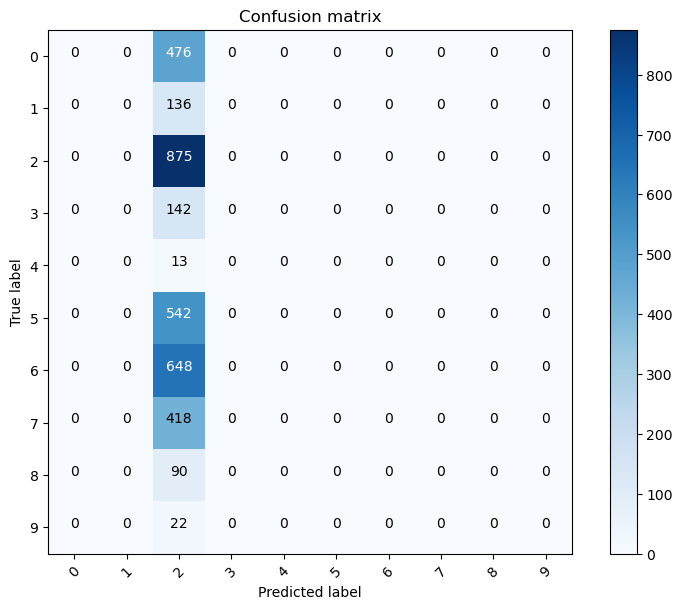

In [17]:
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

#Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(set(labels)))
plt.xticks(tick_marks, set(labels), rotation=45)
plt.yticks(tick_marks, set(labels))

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

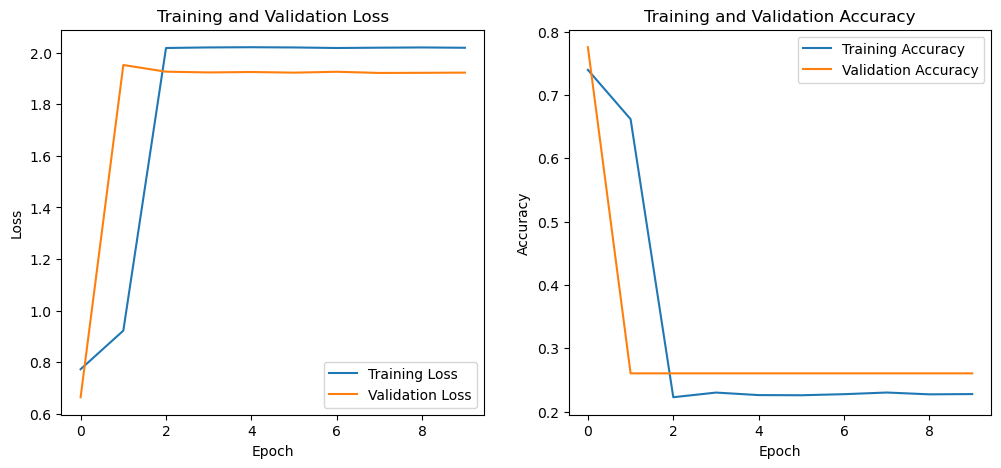

In [18]:
#Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
#Get accuracy of every class
class_accuracy = {}
for i in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[i]
    total = conf_matrix[i].sum()
    correct = conf_matrix[i][i]
    accuracy = correct / total if total > 0 else 0.0
    class_accuracy[class_name] = accuracy

sorted_class_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)

print("Accuracy por clase:")
for class_name, acc in sorted_class_accuracy:
    print(f"{class_name}: {acc}")

# Calcular el accuracy general
accuracy = accuracy_score(val_labels, val_predictions)
print("Accuracy general:", accuracy)

Accuracy por clase:
dogs: 1.0
cats: 0.0
diapering: 0.0
fish aquatic pets: 0.0
fresh flowers live indoor plants: 0.0
hair care: 0.0
health care: 0.0
medical supplies equipment: 0.0
safety: 0.0
strollers: 0.0
Accuracy general: 0.260261748958953


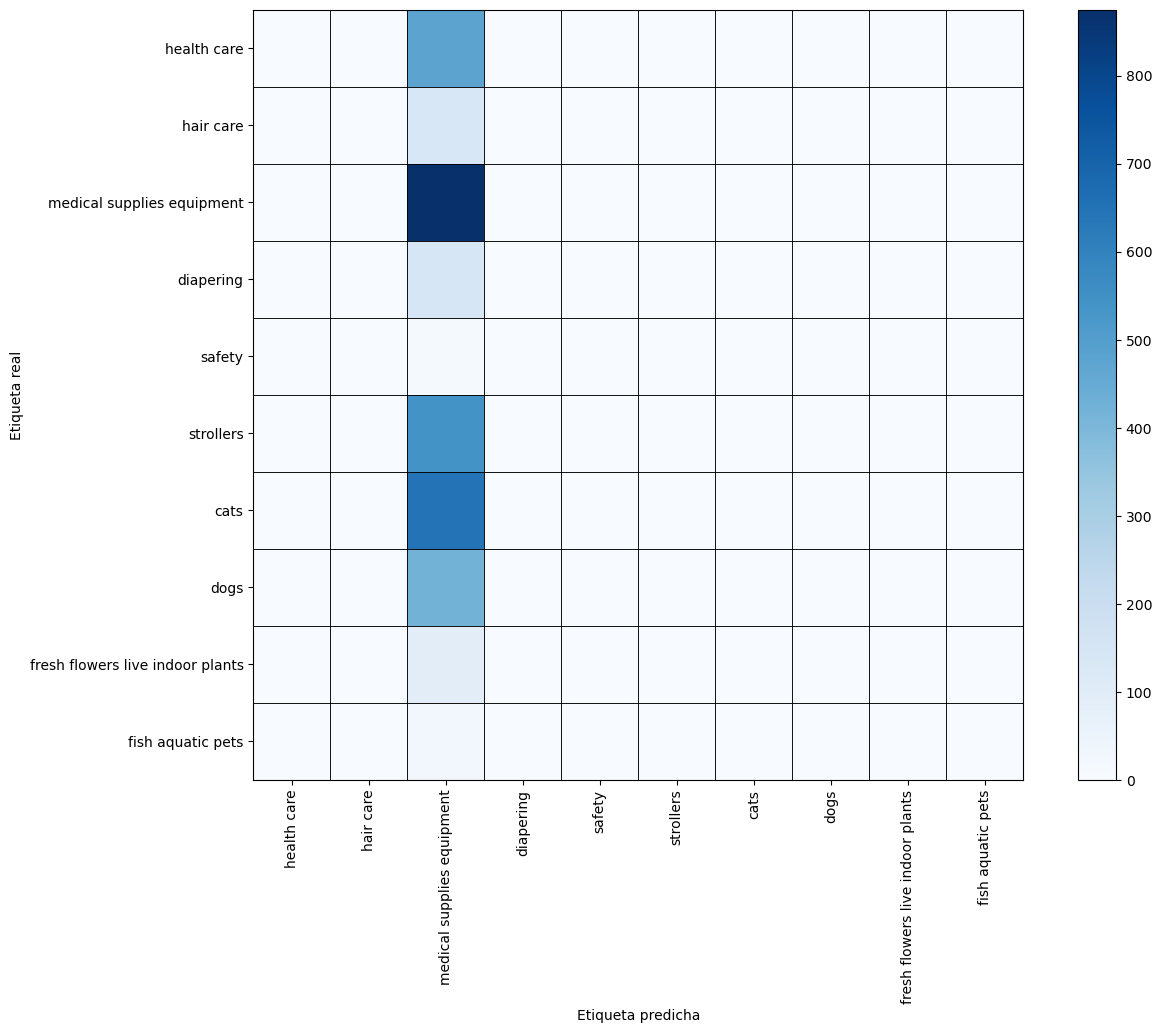

In [20]:
cmap=plt.cm.Blues

plt.figure(figsize=(14, 10))
plt.title("")

plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, original_labels, rotation=90)
plt.yticks(tick_marks, original_labels)

for i in range(num_labels):
        for j in range(num_labels):
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black', fill=None, linewidth=0.5))

plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.show()

In [21]:
model.save("Models/"+name_model+"_model")

2024-04-22 23:34:30.416161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_ids' with dtype int32 and shape [?,?]
	 [[{{node input_ids}}]]
2024-04-22 23:34:31.875469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_ids' with dtype int32 and shape [?,?]
	 [[{{node input_ids}}]]
2024-04-22 23:34:32.016375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_ids' with dtype int32 and shape [?,?]
	 [[{{node input_ids}}]]
2024

INFO:tensorflow:Assets written to: Models/xlnet-base-cased_model/assets


INFO:tensorflow:Assets written to: Models/xlnet-base-cased_model/assets
